# Ozone project for Introduction to Data Science

Load in the Helsinki data in .csv form first.

In [1]:
import pandas as pd
import numpy as np
import glob

# Load in all city data from .csv
def read_city(city):
    files = glob.glob(f'./data/{city}/*.csv')
    city_df = pd.DataFrame()

    for file in files:
        city_df = pd.concat([city_df, pd.read_csv(file)])

    # Rename columns
    city_df = city_df.rename(columns = {'system:time_start': 'Date', 'O3_column_number_density': 'mol/m^2'})

    # Convert to date to datetime
    city_df['Date'] = pd.to_datetime(city_df['Date'])

    # Sort by Date and reset the index
    city_df = city_df.sort_values(by = 'Date')
    city_df = city_df.reset_index(drop = True)

    # Remove the day from date, so that we can just GroupBy date to get the monthly mean. Pandas automatically does not count NaN in mean.
    city_monthly_df = city_df.copy()
    city_monthly_df['Date'] = city_df['Date'].apply(lambda date: date.strftime('%Y-%m'))
    city_monthly_df['Date'] = pd.to_datetime(city_monthly_df['Date'])
    city_monthly_df = city_monthly_df.groupby('Date').mean().reset_index()

    return city_df, city_monthly_df

# Read in the city ozone data
helsinki_all, helsinki_monthly = read_city('Helsinki')

display(helsinki_all)

,Date,mol/m^2
0,2019-01-01,NaN
1,2019-01-01,NaN
2,2019-01-02,NaN
3,2019-01-02,0.130
4,2019-01-02,NaN
...,...,...
12921,2024-09-18,NaN
12922,2024-09-19,NaN
12923,2024-09-19,0.122
12924,2024-09-19,NaN


## EDA

Looking at the date, it is immediately obvious that there are a lot of missing values (NaN). Also one day can have multiple readings, some of which were NaN. We do not need individual days, therefore let's transform the readings to monthly average. Let's visualize the data at this point as well.

In [2]:
# Display monthly mol/m^2 of Helsinki
print('Helsinki monthy data:')
display(helsinki_monthly)

Helsinki monthy data:


,Date,mol/m^2
0,2019-01-01,0.176746
1,2019-02-01,0.171456
2,2019-03-01,0.181606
3,2019-04-01,0.164164
4,2019-05-01,0.168526
...,...,...
64,2024-05-01,0.170227
65,2024-06-01,0.159578
66,2024-07-01,0.151256
67,2024-08-01,0.141938


/tmp/ipykernel_43013/102590693.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


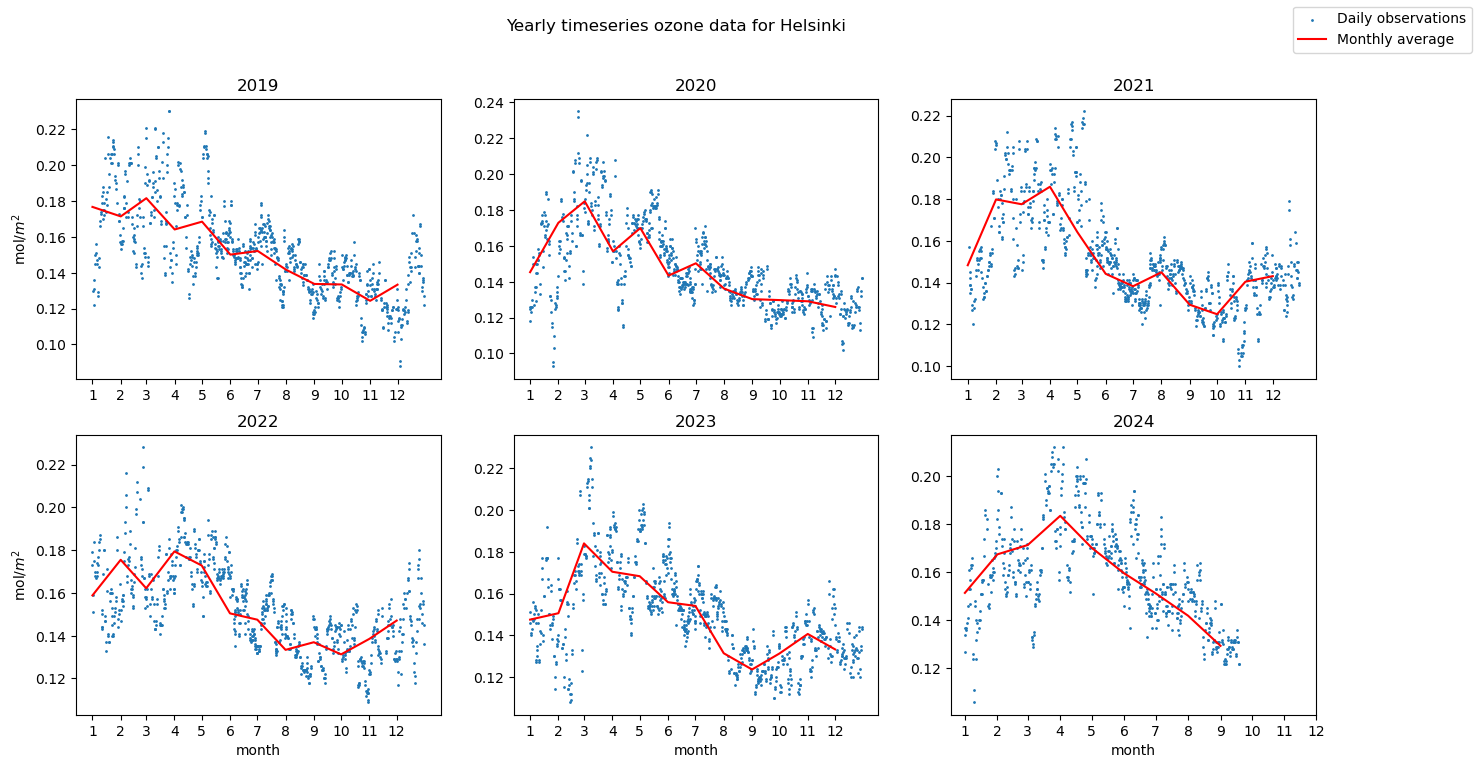

In [3]:
import matplotlib.pyplot as plt

# Draw yearly scatterplots of all ozone values, and the mean
def plot_yearly_ozone_data(df, mean_df, start_year = 2019, end_year = 2024):
    fig, axs = plt.subplots(2, 3)
    fig.suptitle('Yearly timeseries ozone data for Helsinki')
    row = 0

    for year_i in range(end_year - start_year + 1):
        if year_i > 0 and year_i % 3 == 0:
            row = row + 1
        
        year_df = df[(df['Date'] >= f'{year_i + start_year}-01-01') & (df['Date'] < f'{year_i + start_year + 1}-01-01')]
        year_avg_df = mean_df[(mean_df['Date'] >= f'{year_i + start_year}-01-01') & (mean_df['Date'] < f'{year_i + start_year + 1}-01-01')]

        axs[row, year_i % 3].scatter(year_df['Date'], year_df['mol/m^2'], s = 1, marker = 'o')
        axs[row, year_i % 3].plot(year_avg_df['Date'], year_avg_df['mol/m^2'], c='red')

        axs[row, year_i % 3].set_title(f'{year_i + start_year}')
        axs[row, year_i % 3].xaxis.set_ticks([f'{year_i + start_year}-{month:02d}' + '-01' for month in range(1,13)])
        axs[row, year_i % 3].xaxis.set_ticklabels([f'{month}' for month in range(1,13)])

        # Only print the ylabel on the left side axes
        if year_i == 0 or year_i == 3:
            axs[row, year_i % 3].set_ylabel(r'$\text{mol}/m^2$')

        # Only print the xlabel on the lower row
        if year_i > 2:
            axs[row, year_i % 3].set_xlabel('month')
    
    fig.set_figwidth(16)
    fig.set_figheight(8)
    fig.legend(['Daily observations', 'Monthly average'])
    fig.show()

plot_yearly_ozone_data(helsinki_all, helsinki_monthly)

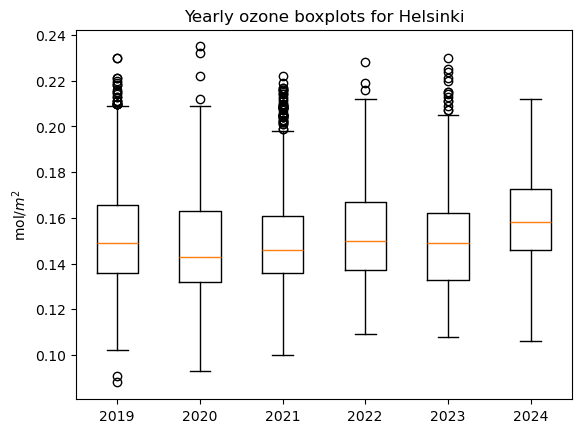

In [4]:
def boxplot_yearly_ozone_data(df, start_year = 2019, end_year = 2024):
    yearly_dens = []
    tick_labels = []

    for year_i in range(end_year - start_year + 1):
        year_df = df[(df['Date'] >= f'{year_i + start_year}-01-01') & (df['Date'] < f'{year_i + start_year + 1}-01-01')]
        tick_labels.append(f'{year_i + start_year}')
        # Have to drop NaNs for boxplot to work. Otherwise it shows only an empty figure.
        yearly_dens.append(year_df['mol/m^2'].dropna())

    plt.title('Yearly ozone boxplots for Helsinki')
    plt.boxplot(yearly_dens)
    plt.ylabel(r'$\text{mol}/{m^2}$')
    plt.xticks(range(1,7), tick_labels)
    plt.show()

boxplot_yearly_ozone_data(helsinki_all)

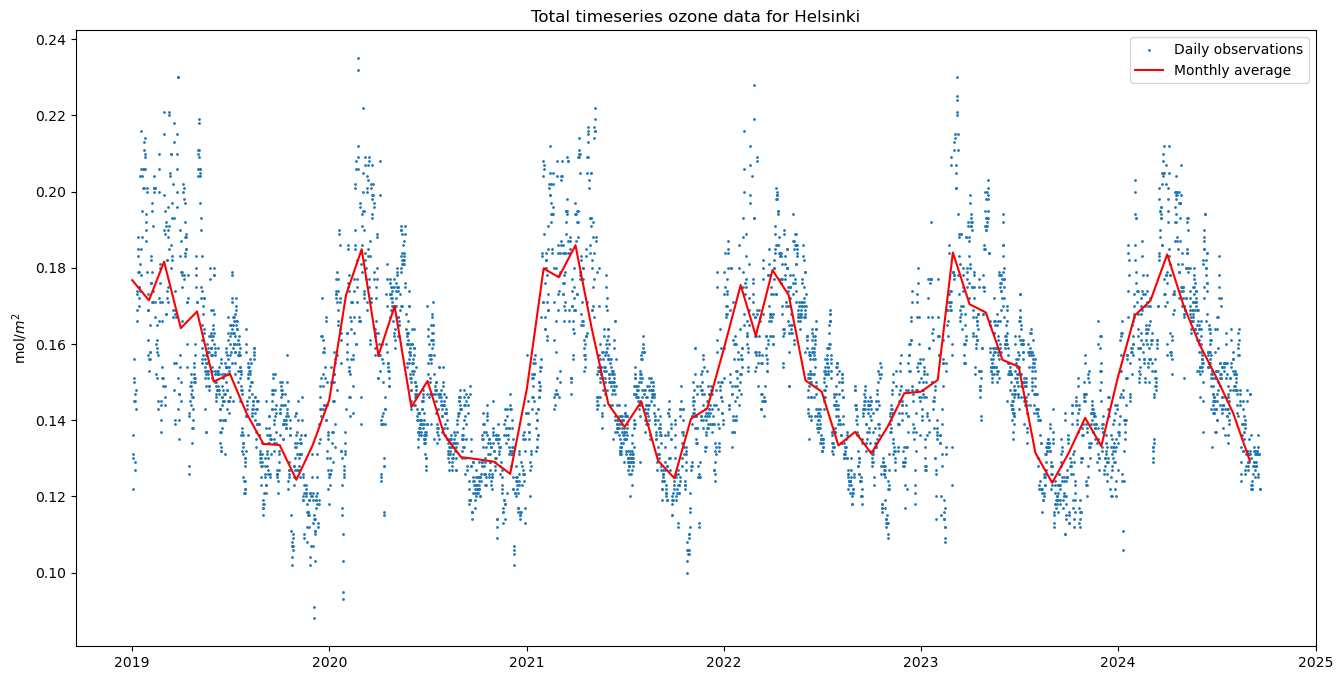

In [5]:
# Plot the whole timeseries as one
plt.figure(figsize = (16, 8))
plt.scatter(helsinki_all['Date'], helsinki_all['mol/m^2'], s = 1, marker = 'o')
plt.plot(helsinki_monthly['Date'], helsinki_monthly['mol/m^2'], c='red')
plt.title('Total timeseries ozone data for Helsinki')
plt.legend(['Daily observations', 'Monthly average'])
plt.ylabel(r'$\text{mol}/m^2$')
plt.show()